# Imports

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy
import glob
import random
import cv2
import pandas as pd
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

# Data handling block

In [29]:
IMG_SIZE = 299
GPU = True
DATA_PATH = "C:/Users/Cerberus/Documents/ML/Project/dataset299"

print("Data path: ",DATA_PATH)
print("Image size: ",IMG_SIZE)
print("GPU enabled: ",GPU)

if GPU == True:
    torch.cuda.set_device(0)
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    print(device)

emotions = ["anger", "contempt", "disgust", "fear", "happy", "sadness", "surprise"] #Emotion list
#emotions = ["fear", "happy","surprise"] #Emotion list

#Define function to get file list, randomly shuffle it and split 60/40
def get_files(emotion): #Define function to get file list, randomly shuffle it and split 60/40
    files = glob.glob("C:/Users/Cerberus/Documents/ML/Project/dataset299//%s//*" %emotion)
    random.shuffle(files)
    training = files[:int(len(files)*0.6)] #get first 60% of file list
    prediction = files[-int(len(files)*0.4):] #get last 40% of file list
    return training, prediction

#Generate training data and label and prediction data and label
def generateEmotionDataset():
    td = []
    tl = []
    pd = []
    pl = []
    for emotion in emotions:
        training, prediction = get_files(emotion)
        #Append data to training and prediction list, and generate labels 0-7
        for item in training:
            #image = cv2.imread(item) #open image
            #gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY) #convert to grayscale
            td.append(item) #append image array to training data list
            tl.append(emotions.index(emotion))

        for item in prediction: #repeat above process for prediction set
            #image = cv2.imread(item)
            #gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
            pd.append(item)
            pl.append(emotions.index(emotion))
       
    data_t= {}
    for i in range(len(td)):
        data_t[td[i]] = tl[i]
    
    data_p= {}
    for i in range(len(pd)):
        data_p[pd[i]] = pl[i]
        
    #randomize
    keys_t =  list(data_t.keys())      # Python 3; use keys = d.keys() in Python 2
    random.shuffle(keys_t)
    keys_p =  list(data_p.keys())      # Python 3; use keys = d.keys() in Python 2
    random.shuffle(keys_p)

    training_data = []
    training_labels = []
        #LOAD data
    for k in keys_t:
        image = cv2.imread(k)
        #gray = cv2.cvtColor(image,cv2.COLOR_RGB)
        training_data.append(image)
        training_labels.append(data_t[k])
    
    prediction_data = []
    prediction_labels = []
    #LOAD data
    for k in keys_p:
        image = cv2.imread(k)
        #gray = cv2.cvtColor(image,cv2.COLOR_RGB)
        prediction_data.append(image)
        prediction_labels.append(data_p[k])
    return training_data, training_labels, prediction_data, prediction_labels

#Personalized data loader for images data
# Need a RGB image (3 channels)
class data_loader_3D(torch.utils.data.Dataset):
    def __init__(self, images_input,label_output):
        Images, Y = [], []
        
        for i in range(len(images_input)):
            Images.append(images_input[i])
            Y.append(label_output[i])

        data = [(x, y) for x, y in zip(Images, Y)]
        self.data = data

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        img = self.data[index][0]      
        #img = img.reshape(3, 299, 299)
        img_tensor = transforms.ToTensor()(img)
        img_tensor.view(3, 299, 299).float()
        label = self.data[index][1]
        return (img_tensor, label)

Data path:  C:/Users/Cerberus/Documents/ML/Project/dataset299
Image size:  299
GPU enabled:  True
cuda:0


# Cross validation data handling

In [36]:
#For cross validation we generate only one set that will be divided later on.
#make_one_set return a data set and a label set
def make_one_set():
    td = []
    tl = []
    for emotion in emotions:
        training, prediction = get_files(emotion)
        #Append data to training and prediction list, and generate labels 0-7
        for item in training:
            #image = cv2.imread(item) #open image
            #gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY) #convert to grayscale
            td.append(item) #append image array to training data list
            tl.append(emotions.index(emotion))

        for item in prediction: #repeat above process for prediction set
            #image = cv2.imread(item)
            #gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
            td.append(item)
            tl.append(emotions.index(emotion))
       
    data_t= {}
    for i in range(len(td)):
        data_t[td[i]] = tl[i]

        
    #randomize
    keys_t =  list(data_t.keys())      # Python 3; use keys = d.keys() in Python 2
    random.shuffle(keys_t)

    training_data = []
    training_labels = []
    #LOAD data
    for k in keys_t:
        image = cv2.imread(k)
        #gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        #gray= cv2.cvtColor(gray, cv2.COLOR_GRAY2BGR)
        training_data.append(image)
        training_labels.append(data_t[k])
    

    return training_data, training_labels


#Yield successive n-sized chunks from l.
def get_chunks(l, n):
    for i in range(0, len(l), n):
        yield l[i:i + n]

#Return n-sized chunks from l.        
def chunks(l, n):
    chunks = list(get_chunks(l, n))

    if(len(chunks[-1]) < n):
        chunks[-2] = chunks[-2] + chunks[-1]
        del chunks[-1]

    return chunks

#Given a list of sets, will return two sets:
# A small one specified by the index
# A big one composed of all the other sets
def get_separated_sets(sets,index):
    big_one = []
    small_one = []
    for i in range(len(sets)):
        if(i == index):
            small_one = sets[i]
        else:
            big_one = big_one + sets[i]
            
    return big_one,small_one

# Stats block

In [56]:
#Returns the number of class
def get_label_quantity(label_set):
    myset = set(label_set)
    labels = np.zeros(len(myset))
    for i in range(len(label_set)):
        labels[label_set[i]] += 1 
    return labels

#Returns the accuracy of a model on the dataset
def get_accuracy_batch(model,dataset):
    correct=0
    batch_size = -1
    for _, data in enumerate(dataset, 0):
        test_x, test_y = data
        
        if GPU == True:
            test_x, test_y = test_x.cuda(), test_y.cuda()
            
        pred, aux =model.forward(test_x)
        
        if batch_size == -1:
            batch_size = len(pred.data)
        
        for i in range(len(pred.data)):
            y_hat=np.argmax(pred.data[i])

            if test_y[i].item()==y_hat.item():
                correct+=1
            
    return correct/(len(dataset)*batch_size)

#Returns a sklearn classifcation report and the confusion matrix
def get_stats_batch(model,dataset):
    actu_all = []
    pred_all = []

    for _, data in enumerate(dataset, 0):
        test_x, test_y = data
        if GPU == True:
            test_x, test_y = test_x.cuda(), test_y.cuda()
        
        pred,aux=model.forward(test_x)
        
        if GPU == True:
            test_y = test_y.cpu()
            pred = pred.cpu()
        
        test_y = test_y.numpy()
        for i in range(len(pred.data)):   
            pred_all.append(np.argmax(pred.data[i].numpy()))
            actu_all.append(test_y[i])


    df_confusion = confusion_matrix(actu_all,pred_all)
    stats = classification_report(actu_all, pred_all)
    return df_confusion,stats

#Do a pretty print of a sklearn confusion matrix
def print_cm(cm, labels, hide_zeroes=False, hide_diagonal=False, hide_threshold=None):
    """pretty print for confusion matrixes"""
    columnwidth = max([len(x) for x in labels] + [5])  # 5 is value length
    empty_cell = " " * columnwidth
    
    # Begin CHANGES
    fst_empty_cell = (columnwidth-3)//2 * " " + "t/p" + (columnwidth-3)//2 * " "
    
    if len(fst_empty_cell) < len(empty_cell):
        fst_empty_cell = " " * (len(empty_cell) - len(fst_empty_cell)) + fst_empty_cell
    # Print header
    print("    " + fst_empty_cell, end=" ")
    # End CHANGES
    
    for label in labels:
        print("%{0}s".format(columnwidth) % label, end=" ")
        
    print()
    # Print rows
    for i, label1 in enumerate(labels):
        print("    %{0}s".format(columnwidth) % label1, end=" ")
        for j in range(len(labels)):
            cell = "%{0}i".format(columnwidth) % cm[i, j]
            if hide_zeroes:
                cell = cell if float(cm[i, j]) != 0 else empty_cell
            if hide_diagonal:
                cell = cell if i != j else empty_cell
            if hide_threshold:
                cell = cell if cm[i, j] > hide_threshold else empty_cell
            print(cell, end=" ")
        print()

# Data loading block

In [27]:
training_data_emo, training_labels_emo, prediction_data_emo, prediction_labels_emo = generateEmotionDataset()    

train_dataset_emo_3D = data_loader_3D(training_data_emo,training_labels_emo)
train_loader_emo_3D = torch.utils.data.DataLoader(dataset=train_dataset_emo_3D, batch_size=8, shuffle=True)
test_dataset_emo_3D = data_loader_3D(prediction_data_emo,prediction_labels_emo)
test_loader_emo_3D = torch.utils.data.DataLoader(test_dataset_emo_3D, batch_size=8, shuffle=True)
print("Training: ",get_label_quantity(training_labels_emo))
print("Testing: ",get_label_quantity(prediction_labels_emo))
print("Sum Training: ", np.sum(get_label_quantity(training_labels_emo)))
print("Sum Testing: ", np.sum(get_label_quantity(prediction_labels_emo)))

Training:  [27. 10. 35. 15. 41. 16. 48.]
Testing:  [18.  7. 23. 10. 27. 11. 32.]
Sum Training:  192.0
Sum Testing:  128.0


# Model and training definition

In [61]:
#Return the inception v3 model
#The parameter model defines which layer will be trained
def get_inceptionV3(layer,verbose=False):
    model_conv = torchvision.models.inception_v3(pretrained='imagenet')
    model_conv.aux_logit=False

    freeze_layers = True
    n_class = len(get_label_quantity(prediction_labels_emo))
    if verbose == True:
        print("# class => ",n_class)

    ## Lets freeze the first few layers. This is done in two stages 
    # Stage-1 Freezing all the layers 
    if freeze_layers == True:
        for i, param in model_conv.named_parameters():
            param.requires_grad = False

    # Since imagenet as 1000 classes ,
    #We need to change our last layer according to the number of classes we have,
    num_ftrs = model_conv.fc.in_features
    model_conv.fc = nn.Linear(num_ftrs, n_class)


    # Stage-2 , Freeze all the layers but the one we want "Conv2d_4a_3*3"
    for name, child in model_conv.named_children():
        if layer == name:
            for params in child.parameters():
                params.requires_grad = True


    # To view which layers are freeze and which layers are not freezed:
    if verbose == True:
        for name, child in model_conv.named_children():
            print(name)
            for name_2, params in child.named_parameters():
                print(name_2, params.requires_grad)
            print('-' * 10)

    print(model_conv.fc.out_features)
        
    return model_conv

#Train the given model on the given training set
def trainClassifier(net,train_set,test_set,criterion,optimizer,epochs,volubile=False):
    history = []
    for epoch in range(1, epochs+1):
        if volubile == True: 
            print('Epoch {}/{}'.format(epoch, epochs))
            print('-' * 10)
        
        for step, data in enumerate(train_set, 0):
            train_x, train_y = data
            #IF GPU
            train_x, train_y = train_x.cuda(), train_y.cuda()
            #print(train_y)
            y_hat, aux = net(train_x)
            
            loss = criterion(y_hat, train_y)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
        history.append(loss.item())
        if volubile == True:  
            epoch_training_acc = get_accuracy_batch(net,train_set)
            print('{} -> Acc: {:.4f}'.format("training",epoch_training_acc))
            epoch_testing_acc = get_accuracy_batch(net,test_set)
            print('{} -> Acc: {:.4f}'.format("testing", epoch_testing_acc))  
    
    return net, history

# Train the model updating the wieghts only on the last layer

In [48]:
epochs=100
model_conv = get_inceptionV3("")
if GPU == True:
    model_conv.cuda()

#Different types of optimizer can be tested for the training 
criterion = torch.nn.CrossEntropyLoss()
#optimizer = torch.optim.Adam(model_conv.parameters())
#optimizer = torch.optim.Adam(model_conv.parameters(), 1.0, (0.9, 0.999), 1.0, 5e-05)
#optimizer = torch.optim.Adagrad(model_conv.parameters(), 1.0, 0, 0.1,0)
#optimizer = torch.optim.ASGD(model_conv.parameters(), 0.1, 0.0001, 0.75, 1000000.0, 0)
optimizer = torch.optim.Adadelta(model_conv.parameters(), 1.0, 0.9, 1e-06, 5e-05)
#optimizer = torch.optim.SGD(model_conv.parameters(),lr=1e-3, momentum=0.9, dampening=0)


classifier_emo,loss_history_emo = trainClassifier(model_conv,train_loader_emo_3D,test_loader_emo_3D,criterion,optimizer,epochs,True)


7
Epoch 1/100
----------
training -> Acc: 0.3958
testing -> Acc: 0.3203
Epoch 2/100
----------
training -> Acc: 0.3073
testing -> Acc: 0.2656
Epoch 3/100
----------
training -> Acc: 0.4896
testing -> Acc: 0.4375
Epoch 4/100
----------
training -> Acc: 0.6875
testing -> Acc: 0.5547
Epoch 5/100
----------
training -> Acc: 0.4635
testing -> Acc: 0.3672
Epoch 6/100
----------
training -> Acc: 0.5885
testing -> Acc: 0.4688
Epoch 7/100
----------
training -> Acc: 0.7396
testing -> Acc: 0.5156
Epoch 8/100
----------
training -> Acc: 0.7448
testing -> Acc: 0.5469
Epoch 9/100
----------
training -> Acc: 0.6406
testing -> Acc: 0.4609
Epoch 10/100
----------
training -> Acc: 0.6771
testing -> Acc: 0.5312
Epoch 11/100
----------
training -> Acc: 0.6979
testing -> Acc: 0.4844
Epoch 12/100
----------
training -> Acc: 0.7396
testing -> Acc: 0.5625
Epoch 13/100
----------
training -> Acc: 0.8021
testing -> Acc: 0.5547
Epoch 14/100
----------
training -> Acc: 0.8333
testing -> Acc: 0.6172
Epoch 15/100


       t/p      anger contempt  disgust     fear    happy  sadness surprise 
       anger        4        1        9        0        0        3        1 
    contempt        0        1        2        0        1        1        2 
     disgust        1        0       19        3        0        0        0 
        fear        0        0        1        4        2        0        3 
       happy        0        0        4        1       20        0        2 
     sadness        3        0        4        0        0        3        1 
    surprise        0        0        2        0        2        0       28 
-----------------------------------------------
              precision    recall  f1-score   support

           0       0.50      0.22      0.31        18
           1       0.50      0.14      0.22         7
           2       0.46      0.83      0.59        23
           3       0.50      0.40      0.44        10
           4       0.80      0.74      0.77        27
           

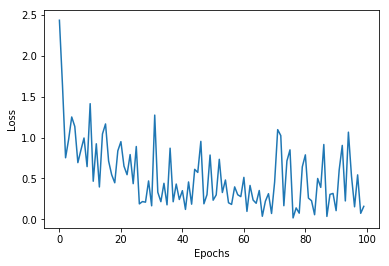

In [49]:
acc_emo = get_accuracy_batch(classifier_emo,test_loader_emo_3D)
confmat_emo, stats_emo = get_stats_batch(classifier_emo,test_loader_emo_3D)

print_cm(confmat_emo,emotions)
print("-----------------------------------------------")
print(stats_emo)
print("Accuracy: %0.2f" % (acc_emo))
plt.plot(np.array(range(len(loss_history_emo))), loss_history_emo)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()

# Cross validation

In [62]:
#Cross validation of the algorithm on the 299x299 images
#The layer parameter indicates which layer of the inception v3 model to train
def cross_validation_score_InceptionV3(data,labels,epochs,layer,cv=5):
    chunk_size = int(len(set_data_cv)/cv)
    #divide the sets by cv
    data_sets = list(chunks(set_data_cv,chunk_size))
    label_sets = list(chunks(set_labels_cv,chunk_size))
    
    nets = []
    histories = []
    accuracies = []
    confmats = []

    for i in range(cv):
        print("------------------------------- ",i,"/",cv)

        
        #foreach cv_sets create training and testing
        training_data, prediction_data  = get_separated_sets(data_sets,i)
        training_labels, prediction_labels = get_separated_sets(label_sets,i)
        print("training :",get_label_quantity(training_labels))
        print("prediction :",get_label_quantity(prediction_labels))
        
        
        train_dataset_emo_3D = data_loader_3D(training_data,training_labels)
        train_loader_emo_3D = torch.utils.data.DataLoader(dataset=train_dataset_emo_3D, batch_size=8, shuffle=True)
        test_dataset_emo_3D = data_loader_3D(prediction_data,prediction_labels)
        test_loader_emo_3D = torch.utils.data.DataLoader(test_dataset_emo_3D, batch_size=8, shuffle=True)
        
        #and train
        #reset all model
        inception_net = get_inceptionV3(layer)
        if GPU == True:
            inception_net.cuda()
        criterion = torch.nn.CrossEntropyLoss()
        #optimizer = torch.optim.Adam(inception_net.parameters())
        optimizer = torch.optim.Adam(inception_net.parameters(), 0.1, (0.9, 0.999), 0.1, 5e-05)
        #optimizer = torch.optim.Adadelta(inception_net.parameters(), 1.0, 0.9, 1e-06, 5e-05)
        c_net,c_hist = trainClassifier(inception_net,train_loader_emo_3D,test_loader_emo_3D,criterion,optimizer,epochs)

        nets.append(c_net)
        histories.append(c_hist)
        
        #and get accuracy
        c_acc = get_accuracy_batch(c_net,test_loader_emo_3D)
        c_confmat = get_stats_batch(c_net,test_loader_emo_3D)
        
        print("Accuracy: %0.2f" % (c_acc))
        
        accuracies.append(c_acc)
        confmats.append(c_confmat)
        
    return nets, histories, accuracies, confmats

In [64]:
#Reloead data
IMG_SIZE = 299
GPU = True
DATA_PATH = "C:/Users/Cerberus/Documents/ML/Project/dataset299"

set_data_cv, set_labels_cv = make_one_set()
print(len(set_labels_cv))

cv = 5
chunk_size = int(len(set_data_cv)/cv)
#divide the sets by cv
data_sets = list(chunks(set_data_cv,chunk_size))
label_sets = list(chunks(set_labels_cv,chunk_size))
    
N_EPOCHS = 100
nets,histories, accuracies, confmats = cross_validation_score_InceptionV3(set_data_cv,set_labels_cv,N_EPOCHS,"")

acc_mean = np.mean(accuracies, axis=0)
acc_dev = np.std(accuracies, axis=0)
print("=========================================")
print("Accuracy: %0.2f (+/- %0.2f)" % (acc_mean, acc_dev * 2))

320
-------------------------------  0 / 5
training : [38. 11. 42. 21. 56. 22. 66.]
prediction : [ 7.  6. 16.  4. 12.  5. 14.]
7
Accuracy: 0.45
-------------------------------  1 / 5
training : [32. 15. 50. 21. 53. 20. 65.]
prediction : [13.  2.  8.  4. 15.  7. 15.]
7
Accuracy: 0.59
-------------------------------  2 / 5
training : [39. 14. 46. 19. 54. 21. 63.]
prediction : [ 6.  3. 12.  6. 14.  6. 17.]
7
Accuracy: 0.58
-------------------------------  3 / 5
training : [37. 14. 45. 21. 55. 26. 58.]
prediction : [ 8.  3. 13.  4. 13.  1. 22.]
7
Accuracy: 0.58
-------------------------------  4 / 5
training : [34. 14. 49. 18. 54. 19. 68.]
prediction : [11.  3.  9.  7. 14.  8. 12.]
7
Accuracy: 0.53
Accuracy: 0.55 (+/- 0.10)


# Now we authorize to update weights in a conv layer

In [68]:
epochs=100

model_conv2 = get_inceptionV3("Conv2d_4a_3x3",True)

if GPU == True:
    model_conv2.cuda()

#Different types of optimizer can be tested for the training 
criterion = torch.nn.CrossEntropyLoss()
#optimizer = torch.optim.Adam(model_conv2.parameters())
#optimizer = torch.optim.Adam(model_conv2.parameters(), 1.0, (0.9, 0.999), 1.0, 5e-05)
#optimizer = torch.optim.Adagrad(model_conv2.parameters(), 1.0, 0, 0.1,0)
#optimizer = torch.optim.ASGD(model_conv2.parameters(), 0.1, 0.0001, 0.75, 1000000.0, 0)
optimizer = torch.optim.Adadelta(model_conv2.parameters(), 1.0, 0.9, 1e-06, 5e-05)
#optimizer = torch.optim.SGD(model_conv2.parameters(),lr=1e-3, momentum=0.9, dampening=0)


classifier_emo2,loss_history_emo2 = trainClassifier(model_conv2,train_loader_emo_3D,test_loader_emo_3D,criterion,optimizer,epochs,True)


# class =>  7
Conv2d_1a_3x3
conv.weight False
bn.weight False
bn.bias False
----------
Conv2d_2a_3x3
conv.weight False
bn.weight False
bn.bias False
----------
Conv2d_2b_3x3
conv.weight False
bn.weight False
bn.bias False
----------
Conv2d_3b_1x1
conv.weight False
bn.weight False
bn.bias False
----------
Conv2d_4a_3x3
conv.weight True
bn.weight True
bn.bias True
----------
Mixed_5b
branch1x1.conv.weight False
branch1x1.bn.weight False
branch1x1.bn.bias False
branch5x5_1.conv.weight False
branch5x5_1.bn.weight False
branch5x5_1.bn.bias False
branch5x5_2.conv.weight False
branch5x5_2.bn.weight False
branch5x5_2.bn.bias False
branch3x3dbl_1.conv.weight False
branch3x3dbl_1.bn.weight False
branch3x3dbl_1.bn.bias False
branch3x3dbl_2.conv.weight False
branch3x3dbl_2.bn.weight False
branch3x3dbl_2.bn.bias False
branch3x3dbl_3.conv.weight False
branch3x3dbl_3.bn.weight False
branch3x3dbl_3.bn.bias False
branch_pool.conv.weight False
branch_pool.bn.weight False
branch_pool.bn.bias False
------

branch3x3dbl_1.bn.weight False
branch3x3dbl_1.bn.bias False
branch3x3dbl_2.conv.weight False
branch3x3dbl_2.bn.weight False
branch3x3dbl_2.bn.bias False
branch3x3dbl_3a.conv.weight False
branch3x3dbl_3a.bn.weight False
branch3x3dbl_3a.bn.bias False
branch3x3dbl_3b.conv.weight False
branch3x3dbl_3b.bn.weight False
branch3x3dbl_3b.bn.bias False
branch_pool.conv.weight False
branch_pool.bn.weight False
branch_pool.bn.bias False
----------
fc
weight True
bias True
----------
7
Epoch 1/100
----------
training -> Acc: 0.2135
testing -> Acc: 0.2109
Epoch 2/100
----------
training -> Acc: 0.3958
testing -> Acc: 0.3672
Epoch 3/100
----------
training -> Acc: 0.6250
testing -> Acc: 0.5000
Epoch 4/100
----------
training -> Acc: 0.7292
testing -> Acc: 0.5547
Epoch 5/100
----------
training -> Acc: 0.6927
testing -> Acc: 0.6484
Epoch 6/100
----------
training -> Acc: 0.7917
testing -> Acc: 0.6406
Epoch 7/100
----------
training -> Acc: 0.7969
testing -> Acc: 0.6406
Epoch 8/100
----------
training 

       t/p      anger contempt  disgust     fear    happy  sadness surprise 
       anger       11        0        4        0        2        0        1 
    contempt        2        4        0        0        0        1        0 
     disgust        1        0       21        0        1        0        0 
        fear        2        0        1        3        2        0        2 
       happy        1        0        6        1       19        0        0 
     sadness        6        0        4        0        1        0        0 
    surprise        2        0        0        2        0        1       27 
-----------------------------------------------
              precision    recall  f1-score   support

           0       0.44      0.61      0.51        18
           1       1.00      0.57      0.73         7
           2       0.58      0.91      0.71        23
           3       0.50      0.30      0.37        10
           4       0.76      0.70      0.73        27
           

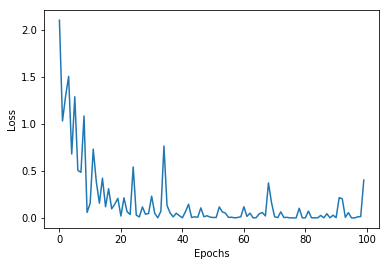

In [83]:
acc_emo2 = get_accuracy_batch(classifier_emo2,test_loader_emo_3D)
confmat_emo2, stats_emo2 = get_stats_batch(classifier_emo2,test_loader_emo_3D)

print_cm(confmat_emo2,emotions)
print("-----------------------------------------------")
print(stats_emo2)
print("Accuracy: %0.2f" % (acc_emo2))
plt.plot(np.array(range(len(loss_history_emo2))), loss_history_emo2)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()

# Cross validation

In [82]:
#Reloead data
IMG_SIZE = 299
GPU = True
DATA_PATH = "C:/Users/Cerberus/Documents/ML/Project/dataset299"

set_data_cv, set_labels_cv = make_one_set()
print(len(set_labels_cv))

cv = 5
chunk_size = int(len(set_data_cv)/cv)
#divide the sets by cv
data_sets = list(chunks(set_data_cv,chunk_size))
label_sets = list(chunks(set_labels_cv,chunk_size))
    
N_EPOCHS = 100
nets,histories, accuracies, confmats = cross_validation_score_InceptionV3(set_data_cv,set_labels_cv,N_EPOCHS,"Conv2d_4a_3x3")

acc_mean = np.mean(accuracies, axis=0)
acc_dev = np.std(accuracies, axis=0)
print("=========================================")
print("Accuracy: %0.2f (+/- %0.2f)" % (acc_mean, acc_dev * 2))

320
-------------------------------  0 / 5
training : [40. 14. 49. 18. 52. 21. 62.]
prediction : [ 5.  3.  9.  7. 16.  6. 18.]
7
Accuracy: 0.75
-------------------------------  1 / 5
training : [32. 15. 44. 20. 55. 21. 69.]
prediction : [13.  2. 14.  5. 13.  6. 11.]
7
Accuracy: 0.70
-------------------------------  2 / 5
training : [34. 14. 49. 19. 54. 19. 67.]
prediction : [11.  3.  9.  6. 14.  8. 13.]
7
Accuracy: 0.61
-------------------------------  3 / 5
training : [37. 12. 49. 22. 56. 21. 59.]
prediction : [ 8.  5.  9.  3. 12.  6. 21.]
7
Accuracy: 0.67
-------------------------------  4 / 5
training : [37. 13. 41. 21. 55. 26. 63.]
prediction : [ 8.  4. 17.  4. 13.  1. 17.]
7
Accuracy: 0.64
Accuracy: 0.68 (+/- 0.10)
